<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/kurs-analiza-danych-2022/blob/main/Tydzie%C5%84%206/MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Sparka

## Utworzenie środowiska pyspark do obliczeń

Tworzymy swoje środowisko z pysparkiem we wenętrzu naszych zasobów chmurowych

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q ftp.ps.pl/pub/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [3]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [5]:
!pip install -q findspark

import findspark
findspark.init()

## Utworzenie sesji z pyspark


Utworzymy testowo sesję aby zobaczyć czy działa. Element ten jest wspólny również gdy systemy sparkowe pracują w sposób ciągły, a nie są tworzone przez naszą sesję.

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

## Podłączenie Google Drive do sesji colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pakiet MLlib

Choć domyślnym sposobem pracy we współczesnych modelach analizy danych jest budowanie ich natywnie w Pythonie, to czasami nie jest możliwe np. uprodukcyjnienie modelu. Apache Spark jest jednym z narzędzi o największych możliwościach przetwarzania. 

Spróbujemy jako przykład użyć tu dużo prostszego zbioru jakim jest Iris

In [8]:
!ls /content/drive/MyDrive/iris.data

/content/drive/MyDrive/iris.data


In [9]:
pola_zbiorczo = '''P_LEN,P_WIDTH,S_LEN,S_WIDTH,SPECIES'''
pola = pola_zbiorczo.split(',')

In [10]:
from pyspark.sql.types import StructType, StringType, IntegerType, BooleanType, FloatType, TimestampType, DateType, ArrayType, MapType
from typing import List, Tuple, Dict, Any
map_python_types_2_spark_types = {
    str : StringType(),
    int : IntegerType(),
    bool : BooleanType(),
    float: FloatType(),
    'timestamp' : TimestampType(),
    'date' : DateType(),
    List[str] : ArrayType(StringType()),
    Tuple[str] : ArrayType(StringType()),
    Dict[str, str] : MapType(StringType(), StringType())
}

column_type_collection = {
    float : [ 'P_LEN','P_WIDTH','S_LEN','S_WIDTH' ],
    str : [ 'SPECIES' ]
}

map_column_names_2_types = {}

for pole in pola:
  for python_type, column_list in column_type_collection.items():
    if pole in column_list:
      map_column_names_2_types[pole] = map_python_types_2_spark_types[python_type]

print(map_column_names_2_types)

{'P_LEN': FloatType, 'P_WIDTH': FloatType, 'S_LEN': FloatType, 'S_WIDTH': FloatType, 'SPECIES': StringType}


In [11]:
schemat = StructType()
for pole, typ in map_column_names_2_types.items():
    schemat = schemat.add(pole, typ, True)

In [12]:
iris = spark.read.format('csv').option("header", False).schema(schemat).load('/content/drive/MyDrive/iris.data')
iris.show(5)

+-----+-------+-----+-------+-----------+
|P_LEN|P_WIDTH|S_LEN|S_WIDTH|    SPECIES|
+-----+-------+-----+-------+-----------+
|  5.1|    3.5|  1.4|    0.2|Iris-setosa|
|  4.9|    3.0|  1.4|    0.2|Iris-setosa|
|  4.7|    3.2|  1.3|    0.2|Iris-setosa|
|  4.6|    3.1|  1.5|    0.2|Iris-setosa|
|  5.0|    3.6|  1.4|    0.2|Iris-setosa|
+-----+-------+-----+-------+-----------+
only showing top 5 rows



In [13]:
iris.printSchema()

root
 |-- P_LEN: float (nullable = true)
 |-- P_WIDTH: float (nullable = true)
 |-- S_LEN: float (nullable = true)
 |-- S_WIDTH: float (nullable = true)
 |-- SPECIES: string (nullable = true)



# Preprocessing 

Dla pełnego wykorzystania zbioru IRIS użyjemy transformacji liczbowej na kolumnie SPECIES aby uzyskać dostęp do wszystkich modeli analitycznych

In [14]:
types = iris.select('SPECIES').distinct().toPandas().values.tolist()
types

[['Iris-virginica'], ['Iris-setosa'], ['Iris-versicolor']]

In [15]:
map_type = [ (typ[0], i) for i, typ in zip(range(3),types) ]
map_type

[('Iris-virginica', 0), ('Iris-setosa', 1), ('Iris-versicolor', 2)]

In [16]:
data = [ [typ, 0 ,0 ,0] for typ, i in map_type]
for typ, i in map_type:
  for i in range(len(data)):
    data[i][1+i] = 1
data

[['Iris-virginica', 1, 0, 0],
 ['Iris-setosa', 0, 1, 0],
 ['Iris-versicolor', 0, 0, 1]]

In [17]:
convert_species = spark.createDataFrame(data=data, schema = ['type']+[typ for typ, _ in map_type])
convert_species.show()

+---------------+--------------+-----------+---------------+
|           type|Iris-virginica|Iris-setosa|Iris-versicolor|
+---------------+--------------+-----------+---------------+
| Iris-virginica|             1|          0|              0|
|    Iris-setosa|             0|          1|              0|
|Iris-versicolor|             0|          0|              1|
+---------------+--------------+-----------+---------------+



In [18]:
iris = (
  iris.alias('left')
  .join(convert_species.alias('right'), iris.SPECIES == convert_species.type , how = 'left')
  .select("left.*", *[f'right.{typ}' for typ, _ in map_type])
)
iris.limit(5).toPandas()

,P_LEN,P_WIDTH,S_LEN,S_WIDTH,SPECIES,Iris-virginica,Iris-setosa,Iris-versicolor
0,6.3,3.3,6.0,2.5,Iris-virginica,1,0,0
1,5.8,2.7,5.1,1.9,Iris-virginica,1,0,0
2,7.1,3.0,5.9,2.1,Iris-virginica,1,0,0
3,6.3,2.9,5.6,1.8,Iris-virginica,1,0,0
4,6.5,3.0,5.8,2.2,Iris-virginica,1,0,0


In [19]:
iris.show(10)

+-----+-------+-----+-------+--------------+--------------+-----------+---------------+
|P_LEN|P_WIDTH|S_LEN|S_WIDTH|       SPECIES|Iris-virginica|Iris-setosa|Iris-versicolor|
+-----+-------+-----+-------+--------------+--------------+-----------+---------------+
|  6.3|    3.3|  6.0|    2.5|Iris-virginica|             1|          0|              0|
|  5.8|    2.7|  5.1|    1.9|Iris-virginica|             1|          0|              0|
|  7.1|    3.0|  5.9|    2.1|Iris-virginica|             1|          0|              0|
|  6.3|    2.9|  5.6|    1.8|Iris-virginica|             1|          0|              0|
|  6.5|    3.0|  5.8|    2.2|Iris-virginica|             1|          0|              0|
|  7.6|    3.0|  6.6|    2.1|Iris-virginica|             1|          0|              0|
|  4.9|    2.5|  4.5|    1.7|Iris-virginica|             1|          0|              0|
|  7.3|    2.9|  6.3|    1.8|Iris-virginica|             1|          0|              0|
|  6.7|    2.5|  5.8|    1.8|Iri

In [20]:
iris_dataset = iris.drop('SPECIES')
iris_dataset.limit(5).toPandas()

,P_LEN,P_WIDTH,S_LEN,S_WIDTH,Iris-virginica,Iris-setosa,Iris-versicolor
0,6.3,3.3,6.0,2.5,1,0,0
1,5.8,2.7,5.1,1.9,1,0,0
2,7.1,3.0,5.9,2.1,1,0,0
3,6.3,2.9,5.6,1.8,1,0,0
4,6.5,3.0,5.8,2.2,1,0,0


## Przygotowanie podziału label-features

In [26]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['P_LEN', 'P_WIDTH', 'S_LEN', 'S_WIDTH'],
    outputCol="features"
    )
stages = [assembler]


In [33]:
from pyspark.sql.functions import col 
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(iris_dataset)
iris_training_ready = (
    pipelineModel
    .transform(iris_dataset)
    .withColumn('labels', col('Iris-virginica'))
    .select('labels', 'features')
)

iris_training_ready.limit(5).toPandas()


,labels,features
0,1,"[6.300000190734863, 3.299999952316284, 6.0, 2.5]"
1,1,"[5.800000190734863, 2.700000047683716, 5.09999..."
2,1,"[7.099999904632568, 3.0, 5.900000095367432, 2...."
3,1,"[6.300000190734863, 2.9000000953674316, 5.5999..."
4,1,"[6.5, 3.0, 5.800000190734863, 2.200000047683716]"


## Podział trening test

In [34]:
train, test = iris_training_ready.randomSplit([0.9, 0.1])
train.limit(5).toPandas()

,labels,features
0,1,"[4.900000095367432, 2.5, 4.5, 1.7000000476837158]"
1,1,"[5.599999904632568, 2.799999952316284, 4.90000..."
2,1,"[5.699999809265137, 2.5, 5.0, 2.0]"
3,1,"[5.800000190734863, 2.700000047683716, 5.09999..."
4,1,"[5.800000190734863, 2.700000047683716, 5.09999..."


In [35]:
train.count()

135

In [36]:
test.count()

15

# Uczenie modeli analitycznych

## Model regresji logistycznej

Rozpoczniemy od prostego modelu regresji logistycznej



In [39]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol = 'features', labelCol = 'labels', maxIter = 10)




Uczymy modelu

In [43]:
trained_model = model.fit(train)

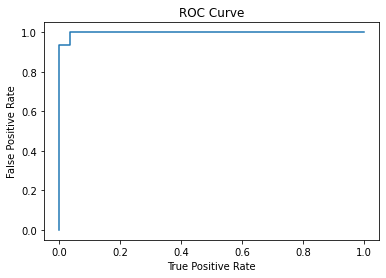

Training set areaUnderROC: 0.9978016609672692


In [47]:
from matplotlib import pyplot as plt

trainingSummary = trained_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

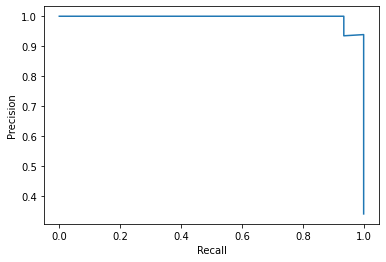

In [48]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Predykcje 

In [49]:
predictions = trained_model.transform(test)
predictions.limit(10).toPandas()

,labels,features,rawPrediction,probability,prediction
0,1,"[5.900000095367432, 3.0, 5.099999904632568, 1....","[-2.3675866550880738, 2.3675866550880738]","[0.08567800538335378, 0.9143219946166462]",1.0
1,1,"[6.400000095367432, 3.200000047683716, 5.30000...","[-5.609765223688639, 5.609765223688639]","[0.003648568193354393, 0.9963514318066456]",1.0
2,1,"[6.699999809265137, 3.299999952316284, 5.69999...","[-7.5899357618152, 7.5899357618152]","[0.0005052581113830025, 0.999494741888617]",1.0
3,1,"[7.400000095367432, 2.799999952316284, 6.09999...","[-4.129043098321722, 4.129043098321722]","[0.01584322727769572, 0.9841567727223043]",1.0
4,0,"[4.300000190734863, 3.0, 1.100000023841858, 0....","[22.83248566712779, -22.83248566712779]","[0.9999999998786675, 1.2133249960299963e-10]",0.0
5,0,"[4.800000190734863, 3.4000000953674316, 1.8999...","[22.52243411830697, -22.52243411830697]","[0.9999999998345637, 1.654363313008389e-10]",0.0
6,0,"[5.099999904632568, 3.5, 1.399999976158142, 0....","[24.333811176736653, -24.333811176736653]","[0.999999999972963, 2.7037039274091512e-11]",0.0
7,0,"[5.199999809265137, 3.4000000953674316, 1.3999...","[24.99847814196695, -24.99847814196695]","[0.9999999999860909, 1.3909096097108886e-11]",0.0
8,0,"[5.199999809265137, 4.099999904632568, 1.5, 0....","[29.209859714988596, -29.209859714988596]","[0.9999999999997937, 2.0627943797535409e-13]",0.0
9,0,"[5.800000190734863, 4.0, 1.2000000476837158, 0...","[30.04178830009596, -30.04178830009596]","[0.9999999999999103, 8.970602038971265e-14]",0.0


## Drzewa decyzyjne

In [51]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'labels', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.limit(10).toPandas()

,labels,features,rawPrediction,probability,prediction
0,1,"[5.900000095367432, 3.0, 5.099999904632568, 1....","[1.0, 41.0]","[0.023809523809523808, 0.9761904761904762]",1.0
1,1,"[6.400000095367432, 3.200000047683716, 5.30000...","[1.0, 41.0]","[0.023809523809523808, 0.9761904761904762]",1.0
2,1,"[6.699999809265137, 3.299999952316284, 5.69999...","[1.0, 41.0]","[0.023809523809523808, 0.9761904761904762]",1.0
3,1,"[7.400000095367432, 2.799999952316284, 6.09999...","[1.0, 41.0]","[0.023809523809523808, 0.9761904761904762]",1.0
4,0,"[4.300000190734863, 3.0, 1.100000023841858, 0....","[84.0, 0.0]","[1.0, 0.0]",0.0
5,0,"[4.800000190734863, 3.4000000953674316, 1.8999...","[84.0, 0.0]","[1.0, 0.0]",0.0
6,0,"[5.099999904632568, 3.5, 1.399999976158142, 0....","[84.0, 0.0]","[1.0, 0.0]",0.0
7,0,"[5.199999809265137, 3.4000000953674316, 1.3999...","[84.0, 0.0]","[1.0, 0.0]",0.0
8,0,"[5.199999809265137, 4.099999904632568, 1.5, 0....","[84.0, 0.0]","[1.0, 0.0]",0.0
9,0,"[5.800000190734863, 4.0, 1.2000000476837158, 0...","[84.0, 0.0]","[1.0, 0.0]",0.0
